# Problem # 1 - Reverse Engineer a Publicly Available Index

## By: Matthew Pribadi

Citations: 

### Objective: 

- The main motivation for this project is to reverse engineer a calculation to determine whether a person should rent or buy a property based on various factors.
<br><br>

### Project Summary
#### *Outcome Variable*
In this project...
<br><br>

### Terminology:
- The **FHFA House Price Index (HPI)** is a broad measure of the movement of single-family house prices.  The HPI is a weighted, repeat-sales index, meaning that it measures average price changes in repeat sales or refinancings on the same properties. This information is obtained by reviewing repeat mortgage transactions on single-family properties whose mortgages have been purchased or securitized by Fannie Mae or Freddie Mac since January 1975.

#### Assumptions/Limitations
- In order to merge the datasets, I am taking yearly averages for all the data sets. This is a major limitation, and would be improved through adding seasonality when I have more time.
- According to the methodology of the paper, they utilized bi-annual mortgage rate averages. For the sake of time, I have taken the average annual mortgage rates.
- I am using Zillow data which only starts from the year 2000

## Import packages

In [2]:
# general
import io
import os
import requests
import warnings
import re

# file handling
from requests.auth import HTTPBasicAuth
from zipfile import ZipFile

# Data Science Libraries
import datetime
import numpy as np
import pandas as pd


# General plotting
import matplotlib.pyplot as plt
import pydot
import seaborn as sns

# Specialized plotting
from IPython.display import Image
from matplotlib.colors import ListedColormap
from mlxtend.plotting import scatterplotmatrix



%matplotlib inline
sns.set_theme(color_codes=True)

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

## Functions for Data Cleaning & Processing

## Read Data, Cleaning and Preprocessing 

In [37]:
url_zillow = '../input/buy-rent-index/County_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv'
url_HPI = '../input/buy-rent-index/HPI_master.csv'
url_rates = '../input/buy-rent-index/MORTGAGE30US.csv'


In [38]:
df_zillow = pd.read_csv(url_zillow)
df_HPI = pd.read_csv(url_HPI)

parse_dates = ['DATE']
df_rates = pd.read_csv(url_rates, parse_dates=parse_dates)


### Clean up Zillow Data

In [39]:
df_zillow.dropna(axis=1)

# df_zillow.set_index(['Metro'], inplace = True)
df_zillow.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,StateCodeFIPS,MunicipalCodeFIPS,1/31/2000,...,10/31/2021,11/30/2021,12/31/2021,1/31/2022,2/28/2022,3/31/2022,4/30/2022,5/31/2022,6/30/2022,7/31/2022
0,3101,0,Los Angeles County,County,CA,CA,Los Angeles-Long Beach-Anaheim,6,37,214234.0,...,800051.0,804554.0,809855.0,814969.0,823298.0,837794.0,855357.0,870495.0,872160.0,871661.0
1,139,1,Cook County,County,IL,IL,Chicago-Naperville-Elgin,17,31,178667.0,...,296654.0,299606.0,302385.0,305006.0,306796.0,309418.0,311618.0,315149.0,318010.0,320045.0
2,1090,2,Harris County,County,TX,TX,Houston-The Woodlands-Sugar Land,48,201,115635.0,...,253539.0,256142.0,259224.0,262435.0,266082.0,270808.0,275920.0,280925.0,284789.0,287346.0
3,2402,3,Maricopa County,County,AZ,AZ,Phoenix-Mesa-Scottsdale,4,13,144742.0,...,427585.0,433747.0,439547.0,445354.0,454125.0,463482.0,475158.0,484143.0,490573.0,488129.0
4,2841,4,San Diego County,County,CA,CA,San Diego-Carlsbad,6,73,225185.0,...,805310.0,812773.0,823998.0,844239.0,864353.0,887333.0,906549.0,919704.0,919171.0,907871.0


In [40]:
df_zillow_metro = df_zillow.iloc[:,[5,6]]

df_zillow_metro.head()

,State,Metro
0,CA,Los Angeles-Long Beach-Anaheim
1,IL,Chicago-Naperville-Elgin
2,TX,Houston-The Woodlands-Sugar Land
3,AZ,Phoenix-Mesa-Scottsdale
4,CA,San Diego-Carlsbad


In [41]:
df_date_zillow = df_zillow.iloc[:,10:].transpose().reset_index().rename(columns={'index':'date'})
df_date_zillow.set_index(['date']).head()

,0,1,2,3,4,5,6,7,8,9,...,2826,2827,2828,2829,2830,2831,2832,2833,2834,2835
date,,,,,,,,,,,,,,,,,,,,,
2/29/2000,214343.0,178963.0,115631.0,145123.0,226411.0,276049.0,229889.0,133973.0,116119.0,255277.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3/31/2000,215321.0,179652.0,115401.0,145585.0,227738.0,277794.0,231376.0,134428.0,116220.0,257174.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4/30/2000,217094.0,180868.0,115375.0,146495.0,230698.0,281431.0,234507.0,135355.0,116455.0,260061.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5/31/2000,219299.0,182273.0,115323.0,147405.0,233537.0,284474.0,237492.0,136043.0,116708.0,262475.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6/30/2000,221313.0,183486.0,115565.0,148089.0,237218.0,287712.0,240621.0,136756.0,116951.0,264748.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
df_date_zillow['date'] = pd.to_datetime(df_date_zillow['date'])

In [46]:
df_agg_date_zillow = df_date_zillow.groupby(df_date_zillow['date']
                                            .map(lambda x: x.year)).agg('mean').transpose()\
                                            .assign(Index=range(len(df_agg_date_zillow))).set_index('Index')

df_agg_date_zillow.reindex_like(df_zillow_metro).tail()

,State,Metro
2831,NaN,NaN
2832,NaN,NaN
2833,NaN,NaN
2834,NaN,NaN
2835,NaN,NaN


In [44]:
df_cleaned_zillow = pd.concat([df_zillow_metro, df_agg_date_zillow], axis=1).dropna(axis=0)

In [45]:
df_cleaned_zillow.set_index(['State','Metro']).head()

,,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
State,Metro,,,,,,,,,,,,,,,,,,,,,
CA,Los Angeles-Long Beach-Anaheim,223455.727273,244915.333333,278956.916667,332427.000000,414645.333333,507331.250000,577241.500000,571906.750000,480673.583333,400439.000000,...,433339.666667,478676.666667,503619.000000,538231.250000,573826.250000,618283.166667,626792.916667,664316.583333,760641.583333,849390.571429
IL,Chicago-Naperville-Elgin,185382.454545,202676.916667,220118.833333,238296.333333,258792.666667,284954.833333,307319.416667,308790.500000,284789.000000,246325.166667,...,196368.583333,213428.583333,221125.583333,230626.083333,243179.333333,253550.333333,256811.583333,260614.416667,286555.666667,312291.714286
TX,Houston-The Woodlands-Sugar Land,116144.818182,117806.583333,121198.166667,125020.333333,132811.272727,138696.916667,140670.750000,144953.666667,143286.833333,139377.333333,...,141621.583333,156910.166667,171247.166667,179426.083333,186119.666667,193853.750000,202217.416667,210116.083333,238656.083333,275472.142857
AZ,Phoenix-Mesa-Scottsdale,148805.181818,156896.916667,164427.416667,173112.583333,188251.700000,249207.666667,305123.833333,287577.416667,233535.750000,175482.916667,...,188819.916667,206017.000000,217520.916667,232751.666667,247256.916667,265560.250000,281037.583333,309859.666667,392685.833333,471566.285714
CA,San Diego-Carlsbad,241432.545455,279540.250000,319518.583333,382794.250000,470920.416667,551726.416667,557722.250000,519208.000000,439524.666667,374785.333333,...,417458.916667,456225.750000,473569.750000,505271.416667,539506.750000,577130.416667,585371.750000,623129.583333,754507.583333,892745.714286


### Clean HPI Data

In [47]:
df_red = df_HPI[df_HPI['yr']>=2000]

df_red.head()

,hpi_type,hpi_flavor,frequency,level,place_name,place_id,yr,period,index_nsa,index_sa
108,traditional,purchase-only,monthly,USA or Census Division,East North Central Division,DV_ENC,2000,1,149.75,150.19
109,traditional,purchase-only,monthly,USA or Census Division,East North Central Division,DV_ENC,2000,2,149.27,149.33
110,traditional,purchase-only,monthly,USA or Census Division,East North Central Division,DV_ENC,2000,3,151.32,150.78
111,traditional,purchase-only,monthly,USA or Census Division,East North Central Division,DV_ENC,2000,4,152.35,151.46
112,traditional,purchase-only,monthly,USA or Census Division,East North Central Division,DV_ENC,2000,5,153.56,151.81


In [48]:
df_yr_HPI = df_red.groupby(['place_name','yr']).agg({'index_nsa': np.mean})

df_yr_HPI.head()

index_nsa
place_name  yr             
Abilene, TX 2000   115.0175
            2001   119.9475
            2002   123.2600
            2003   126.5350
            2004   132.1900

### Clean Mortgage Rates

In [49]:
df_rates.head()

,DATE,MORTGAGE30US
0,1971-04-02,7.33
1,1971-04-09,7.31
2,1971-04-16,7.31
3,1971-04-23,7.31
4,1971-04-30,7.29


<AxesSubplot:xlabel='DATE'>

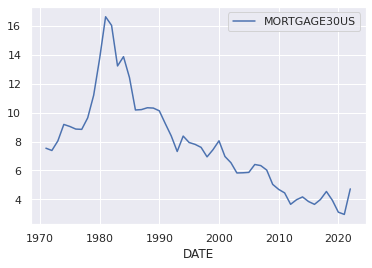

In [54]:
#Generate a list of average mortgage rates per year in the United States

df_avg_rates = df_rates.groupby(df_rates['DATE'].map(lambda x: x.year)).agg({'MORTGAGE30US': np.mean})

df_avg_rates.plot()